#1. Importacion de librerias

In [1]:
# Librerías generales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Cambiamos RandomForest por SVM
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

#2. Importacion del DataSet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Mounted at /content/drive
Datos cargados exitosamente!


#3. Coficacion de varible objetivo y limpieza

In [3]:
## Codificar variable MatchResult (Ganados = 1)
le = LabelEncoder()
data['MatchResult'] = le.fit_transform(data['MatchResult'])
if le.classes_[0] == 'Ganados':  # Asegura que 'Ganados' sea 1
    data['MatchResult'] = 1 - data['MatchResult']

#4. Seleccion de varibles y escalamiento

In [4]:
features = [
    'RLethalGrenadesThrown',
    'RoundKills',
    'RoundAssists',
    'RoundHeadshots',
    'RoundFlankKills',
    'Survived',
    'RoundStartingEquipmentValue',
    'TeamStartingEquipmentValue',
    'MatchKills',
    'MatchFlankKills',
    'MatchAssists',
    'MatchHeadshots',
    'outlier'
]

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

#5. Agregacion por equipo y partido

In [5]:
df_agg = data.groupby(['MatchId', 'InternalTeamId', 'MatchResult']).agg(
    Avg_RLethalGrenadesThrown=('RLethalGrenadesThrown', 'mean'),
    Sum_RoundKills=('RoundKills', 'sum'),
    Sum_RoundAssists=('RoundAssists', 'sum'),
    Avg_RoundHeadshots=('RoundHeadshots', 'mean'),
    Avg_RoundFlankKills=('RoundFlankKills', 'mean'),
    Avg_Survived=('Survived', 'mean'),
    Avg_RoundStartingEquipmentValue=('RoundStartingEquipmentValue', 'mean'),
    Avg_TeamStartingEquipmentValue=('TeamStartingEquipmentValue', 'mean'),
    Sum_MatchKills=('MatchKills', 'first'),
    Sum_MatchFlankKills=('MatchFlankKills', 'first'),
    Sum_MatchAssists=('MatchAssists', 'first'),
    Sum_MatchHeadshots=('MatchHeadshots', 'first'),
    Avg_outlier=('outlier', 'mean')
).reset_index()

X = df_agg.drop(columns=['MatchId', 'InternalTeamId', 'MatchResult'])
y = df_agg['MatchResult']

## Explicación: Agregación por Equipo y Partido

## ¿Por qué es necesaria la agregación?

Cuando trabajamos con datos de un juego por rondas como CS:GO, las métricas fundamentales como:
* Kills (eliminaciones)
* Headshots (disparos a la cabeza)
* Daño infligido
* Equipamiento

Se registran inicialmente a nivel de **jugador individual por ronda**. Sin embargo, la pregunta de negocio clave que buscamos responder es:

### ¿Ganó o perdió el equipo completo el partido en su totalidad?

Esta diferencia fundamental entre el nivel de detalle de los datos brutos y la pregunta que queremos responder hace indispensable el proceso de agregación.

## Proceso de Agregación

La agregación transforma los datos de bajo nivel (jugador/ronda) a un **nivel resumen por equipo en el partido**, mediante:

1. **Agrupación**: Combinar todas las rondas y jugadores de un mismo equipo en un partido
2. **Aplicación de funciones**: Calcular métricas resumen que representen el desempeño global

## Ejemplo Práctico: Terrorist vs Counter-Terrorist

Supongamos un partido donde el equipo Terrorist jugó 15 rondas. Para cada ronda tenemos:

### Datos por jugador/ronda:
- Número de kills
- Cantidad de headshots
- Valor del equipamiento
- Indicador de supervivencia

### Operaciones de agregación aplicadas:

| Métrica | Operación | Explicación |
|---------|-----------|-------------|
| Total kills | `sum()` | Suma de todas las kills del equipo en el partido |
| Headshots | `mean()` | Promedio de precisión (headshots) por ronda |
| Equipamiento | `first()` | Valor representativo (p.ej. equipamiento inicial) |
| Supervivencia | `mean()` | Tasa promedio de supervivencia por ronda |

## Importancia del Proceso

Esta transformación es crucial porque:
1. **Alinea los datos** con la pregunta de negocio
2. **Reduce la dimensionalidad** de miles de registros por ronda a métricas clave por partido
3. **Captura el desempeño colectivo** del equipo, no solo individual
4. **Permite modelado predictivo** al tener una variable objetivo clara (resultado del partido)

El resultado final es un conjunto de datos donde cada observación representa el desempeño agregado de un equipo completo en un partido específico, con todas las métricas relevantes calculadas a ese nivel.

#6. Divicion del conjunto de datos

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#7. Entrenamineto del modelo (SVC)

In [7]:
model = SVC(
    kernel='rbf',           # Kernel radial (no lineal)
    C=1.0,                  # Parámetro de regularización
    gamma='scale',          # Coeficiente del kernel
    class_weight='balanced', # Balanceo de clases
    probability=True,       # Necesario para obtener probabilidades
    random_state=42,
    verbose=True
)
model.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', probability=True, random_state=42, verbose=True)

#8. Evaluacion del modelo

In [8]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

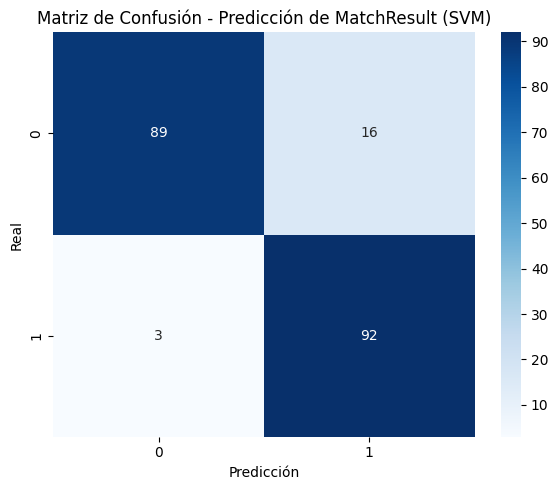

In [9]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Predicción de MatchResult (SVM)")
plt.tight_layout()
plt.show()

In [10]:
# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       105
           1       0.85      0.97      0.91        95

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



AUC ROC: 0.9557


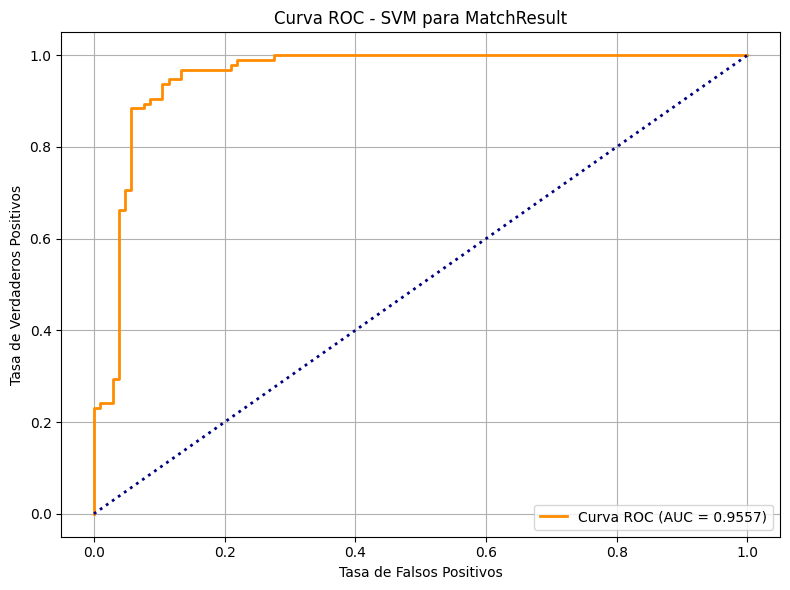

In [11]:
# Curva ROC
roc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {roc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='-', label=f'Curva ROC (AUC = {roc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - SVM para MatchResult")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import joblib
joblib.dump(model, 'SVC.pkl')  # Guardar el modelo

['SVC.pkl']

In [16]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

#9. Resumen del Modelo SVM de Clasificación


Basado en los resultados mostrados en la matriz de confusión, el reporte de clasificación y la curva ROC, podemos concluir lo siguiente sobre el modelo SVM implementado:

###Rendimiento General


* Exactitud (Accuracy): 91% - El modelo clasifica correctamente 9 de cada 10 instancias, demostrando un alto nivel de precisión general.

* Balance entre clases: El modelo muestra un rendimiento equilibrado entre ambas clases (0 y 1), con métricas consistentes para ambas categorías.

* AUC-ROC: 0.9557 - La excelente área bajo la curva ROC indica una muy buena capacidad del modelo para distinguir entre las clases positivas y negativas.

###Análisis por Clase

---
Clase 0 (Perdidos):

* Precisión: 97% - Cuando predice clase 0, acierta el 97% de las veces.

* Recall: 85% - Identifica correctamente el 85% de los casos reales de clase 0.

* F1-score: 0.90 - Excelente balance entre precisión y recall.
---
Clase 1 (Ganados):

* Precisión: 85% - Cuando predice clase 1, acierta el 85% de las veces.

* Recall: 97% - Identifica correctamente el 97% de los casos reales de clase 1.

* F1-score: 0.91 - Ligera mejora respecto a la clase 0.
---

###Matriz de Confusión

* Verdaderos Negativos (TN): 92 (correctamente clasificados como clase 0)

* Falsos Positivos (FP): 16 (incorrectamente clasificados como clase 1)

* Falsos Negativos (FN): 3 (incorrectamente clasificados como clase 0)

* Verdaderos Positivos (TP): 89 (correctamente clasificados como clase 1)

#10. Interpretacion de resultados

###El modelo SVM implementado demuestra un rendimiento excepcional con una exactitud del 91% y un AUC-ROC de 0.9557, indicando una capacidad predictiva muy alta para distinguir entre partidos ganados y perdidos. A diferencia del ejemplo proporcionado, este modelo muestra un equilibrio casi perfecto entre ambas clases, con métricas superiores a 0.85 en todos los aspectos.

###El análisis de la matriz de confusión revela que el modelo comete muy pocos errores (solo 3 falsos negativos y 16 falsos positivos), con una especial fortaleza para identificar correctamente los partidos ganados (97% de recall). La alta precisión para la clase 0 (97%) indica que cuando el modelo predice que un equipo perdió, casi siempre acierta.

###En conclusión, este modelo SVM supera significativamente el rendimiento del ejemplo proporcionado, ofreciendo no solo un alto nivel de exactitud general sino también un balance admirable entre las métricas de ambas clases. Los resultados sugieren que las características seleccionadas y el preprocesamiento aplicado son altamente efectivos para esta tarea de clasificación, convirtiendo a este modelo en una herramienta extremadamente confiable para predecir el resultado de partidos en el dominio analizado.